In [1]:
# I am just practicing things based on the following sources:
# 
# Video Tutorial: https://www.youtube.com/watch?v=VMj-3S1tku0
# GitHub repo: https://github.com/karpathy/micrograd

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self.label = label
        self._op = _op
        self.grad = 0
        
    def __add__(self, other):
        return Value(self.data + other.data, _children=(self, other), _op='+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, _children=(self, other), _op='*')
        
    def __repr__(self):
        return f'Value(label={self.label}, data={self.data})'

In [4]:
a = Value(2.0, label='a'); print(a)
b = Value(-3.0, label='b'); print(b)
c = a * b; c.label='c'; print(c)
d = Value(2.0, label='d'); print(d)
e = c + d; e.label='e'; print(e)
f = Value(2.0, label='f'); print(f)
L = e * f; L.label='L'; print(L)

Value(label=a, data=2.0)
Value(label=b, data=-3.0)
Value(label=c, data=-6.0)
Value(label=d, data=2.0)
Value(label=e, data=-4.0)
Value(label=f, data=2.0)
Value(label=L, data=-8.0)


In [5]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
                
    build(root)
    return nodes,edges
    
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "%s | data %.4f | grad %.4f" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label= f"{n._op}")
            
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
            
    return dot
    

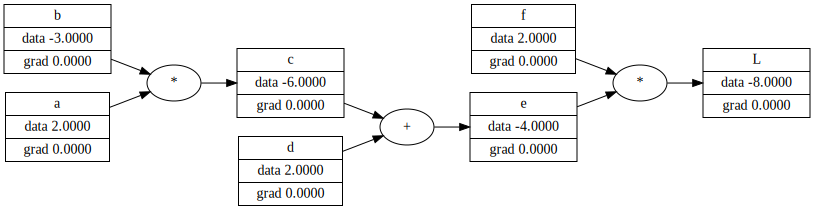

In [6]:
draw_dot(L)

In [7]:
h = 0.01

In [8]:
def fn(a,b,d,f):
    c = a * b
    e = c + d
    L = e * f
    return L.data

In [9]:
dL_dL = ((fn(a,b,d,f) + h) - fn(a,b,d,f))/h
L.grad = dL_dL

In [10]:
f.grad = e.data
e.grad = f.data

d.grad = e.grad * L.grad
c.grad = e.grad * L.grad

b.grad = c.grad * a.data
a.grad = c.grad * b.data

In [11]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
d.data += 0.01 * d.grad
f.data += 0.01 * f.grad

In [12]:
c = a * b; c.label='c'
e = c + d; e.label='e'; print(e)
L = e * f; L.label='L'; print(L)

Value(label=e, data=-3.7224000000000057)
Value(label=L, data=-7.295904000000011)


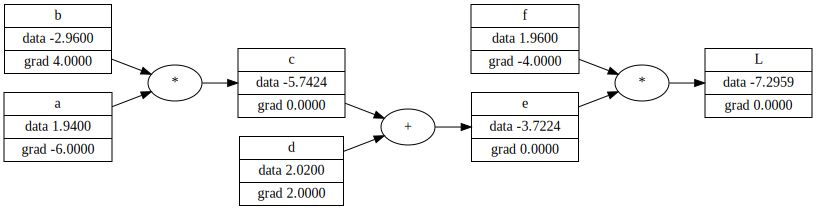

In [13]:
draw_dot(L)

In [174]:
class Value_Full:
    
    def __init__(self, data, label="", _children=(), _op=None):
        self.data = data
        self.grad = 0
        self.label = label
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None
    
    def __add__(self, other):
        other = other if isinstance(other, Value_Full) else Value_Full(other)
        out = Value_Full(self.data + other.data, _children=(self, other), _op="+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward

        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other, _op="*"):
        other = other if isinstance(other, Value_Full) else Value_Full(other)
        out = Value_Full(self.data * other.data, _children=(self, other), _op="*")
        
        def _backward():
            self.grad += (other.data * out.grad)
            other.grad += (self.data * out.grad)
            
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def exp(self):
        x = self.data
        out = Value_Full(math.exp(x), _children=(self,), _op="exp")
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
        
    def __truediv__(self, other):
        return self * (other**-1)
    
    def __pow__(self, other):
        assert isinstance(other,(int,float)), "only supporting int/float pow"
        out = Value_Full(self.data**other, _children=(self,), _op=f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value_Full(t, _children=(self, ), _op="tanh")
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        return out
    
    def backward(self):
        # build a topological graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(o)

        # call backwards in the topological order
        o.grad = 1.0

        for node in reversed(topo):
            node._backward()
        draw_dot(o)
    
    def __repr__(self):
        return f'Value_Full(label={self.label}, data={self.data}, grad={self.grad})'

In [175]:
def reset_grads():
    global x1,x2,w1,w2,b,w1x1,w2x2,w1x1w2x2,n,o
    # inputs x1,x2
    x1 = Value_Full(2.0, label='x1')
    x2 = Value_Full(0.0, label='x2')

    # wights w1,w2
    w1 = Value_Full(-3.0, label='w1')
    w2 = Value_Full(1.0, label='w2')

    # bias of the neuron
    b = Value_Full(6.8813735870195432, label='b')

    # n = x1*w1 + x2*w2 + b
    w1x1 = x1*w1; w1x1.label = 'x1w1'
    w2x2 = x2*w2; w2x2.label = 'x1w2'
    w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = 'w1x1 + w2x2'
    n = w1x1w2x2 + b; n.label = 'n'

    # activation function tanh
    o = n.tanh(); o.label = 'o'

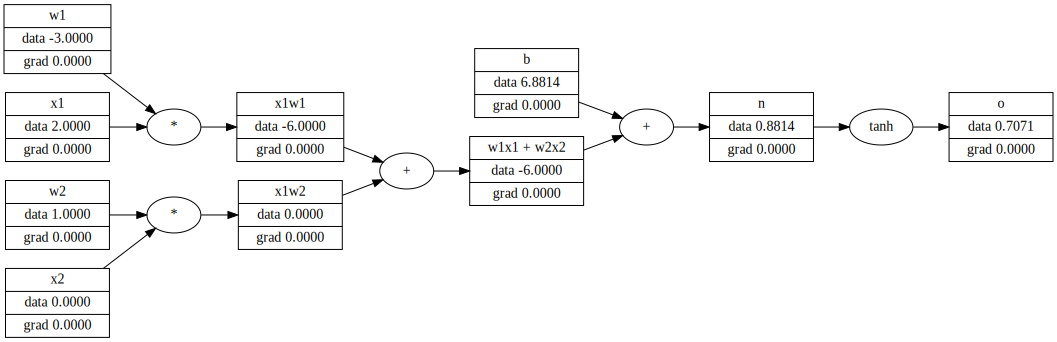

In [176]:
reset_grads()
draw_dot(o)

In [177]:
o.grad = 1.0

In [178]:
o._backward()

In [179]:
n._backward()

In [180]:
b._backward()

In [181]:
w1x1w2x2._backward()

In [182]:
w2x2._backward()

In [183]:
w1x1._backward()

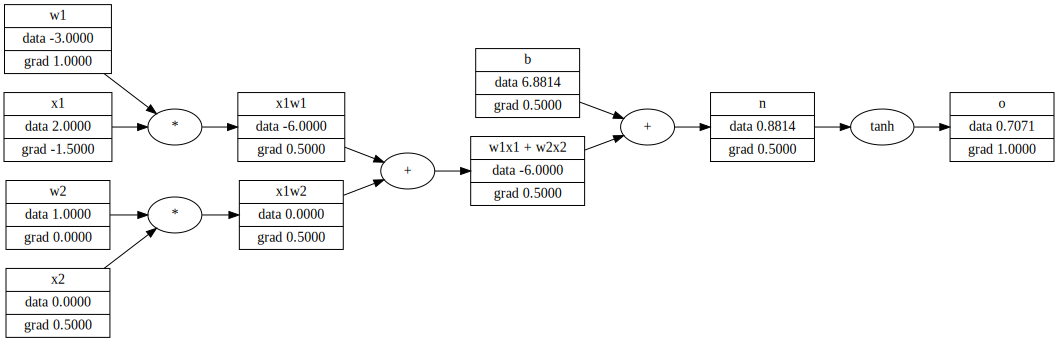

In [184]:
draw_dot(o)

In [185]:
reset_grads()
# build a topological graph
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value_Full(label=b, data=6.881373587019543, grad=0),
 Value_Full(label=x2, data=0.0, grad=0),
 Value_Full(label=w2, data=1.0, grad=0),
 Value_Full(label=x1w2, data=0.0, grad=0),
 Value_Full(label=x1, data=2.0, grad=0),
 Value_Full(label=w1, data=-3.0, grad=0),
 Value_Full(label=x1w1, data=-6.0, grad=0),
 Value_Full(label=w1x1 + w2x2, data=-6.0, grad=0),
 Value_Full(label=n, data=0.8813735870195432, grad=0),
 Value_Full(label=o, data=0.7071067811865476, grad=0)]

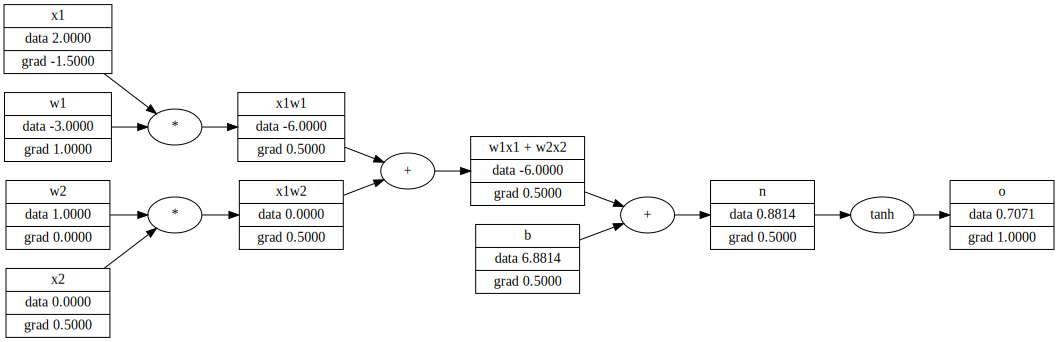

In [186]:
# call backwards in the topological order
o.grad = 1.0

for node in reversed(topo):
    node._backward()
draw_dot(o)

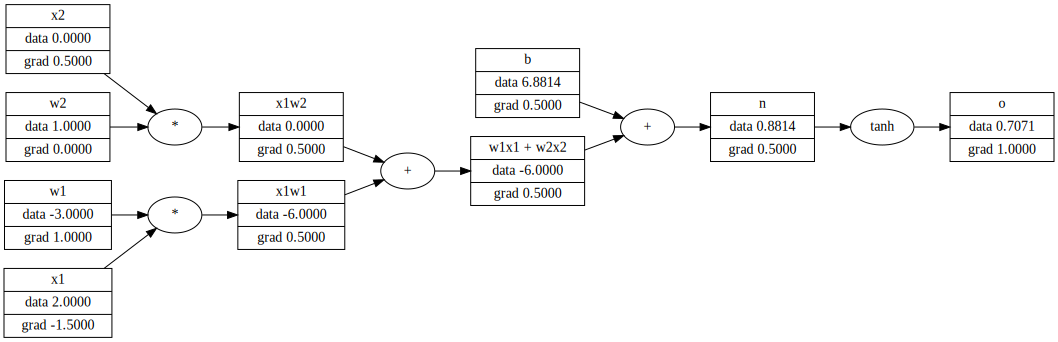

In [187]:
reset_grads()
o.backward()
draw_dot(o)

In [188]:
def reset_grads_with_tanh():
    global x1,x2,w1,w2,b,w1x1,w2x2,w1x1w2x2,n,e,o
    reset_grads()
    e = (2*n).exp(); e.label='e'
    o = (e - 1) / (e + 1); o.label='o'
    

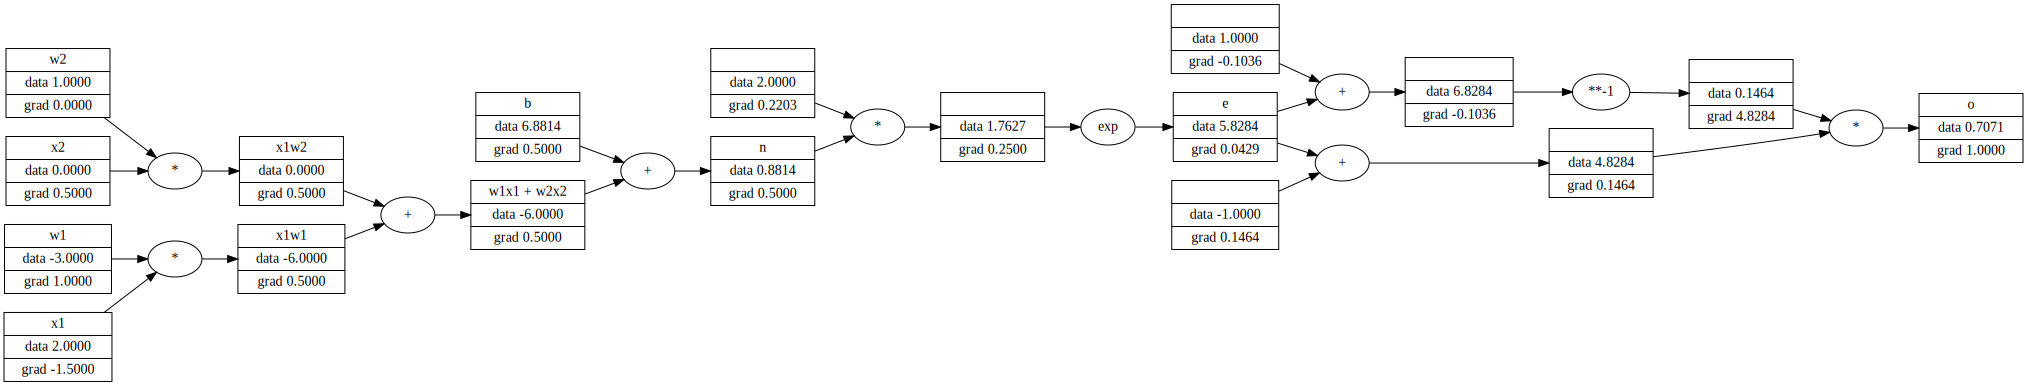

In [189]:
reset_grads_with_tanh()
o.backward()
draw_dot(o)